# Q3 & Q4 classification analysis
For questions 3 and 4, it mainly discusses category of EMS call outcome, provider tenure, fire station location and provider shift assignment.   

dependent valuable: EMS call outcome  
Independent valuable:tenure, fire station location, shift assignment  

We use category of EMS call outcome as the dependent variable and the remaining attributes as independent variables to establish a machine learning model.  
The purpose of classification analysis is to explore whether it is possible to predict the dependent variable through the independent variable, and the importance of the independent variable to the dependent variable.

## 1. Load packages and overview

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df0 = pd.read_excel('/Users/luxu/Desktop/DEAN690/dataset/DAEN 690 2021-02-25.xlsx')

In [5]:
df0.head()

,PatientId,FRDPersonnelID,Shift,UnitId,FireStation,Battalion,PatientOutcome,PatientGender,CrewMemberRoles,DispatchTime,FRDPersonnelGender,FRDPersonnelStartDate
0,479838,6ED7C99E-9E01-E211-B5F5-78E7D18CFD3C,A - Shift,M404,4,401,Standby (No Services Performed),NaN,"Primary Patient Caregiver-At Scene,Primary Pat...",2018-01-01 00:29:02,Male,1997-08-18
1,479838,F39A55F0-C619-E511-80CA-001DD8B71D38,A - Shift,M404,4,401,Standby (No Services Performed),NaN,"Driver-Transport,Other Patient Caregiver-At Scene",2018-01-01 00:29:02,Male,2007-02-19
2,479838,D6D3C99E-9E01-E211-B5F5-78E7D18CFD3C,A - Shift,M404,4,401,Standby (No Services Performed),NaN,"Intern/Student,Other Patient Caregiver-At Scen...",2018-01-01 00:29:02,Male,2008-08-18
3,479839,71D4C99E-9E01-E211-B5F5-78E7D18CFD3C,A - Shift,M401,1,402,No Treatment/Transport Required,NaN,"Primary Patient Caregiver-At Scene,Primary Pat...",2018-01-01 00:40:54,Male,2011-10-24
4,479839,F9D4C99E-9E01-E211-B5F5-78E7D18CFD3C,A - Shift,M401,1,402,No Treatment/Transport Required,NaN,"Driver-Response,Driver-Transport",2018-01-01 00:40:54,Male,2012-02-27


In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543774 entries, 0 to 543773
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   PatientId              543774 non-null  int64         
 1   FRDPersonnelID         543774 non-null  object        
 2   Shift                  543774 non-null  object        
 3   UnitId                 543774 non-null  object        
 4   FireStation            543774 non-null  int64         
 5   Battalion              543774 non-null  int64         
 6   PatientOutcome         543772 non-null  object        
 7   PatientGender          412396 non-null  object        
 8   CrewMemberRoles        543774 non-null  object        
 9   DispatchTime           543774 non-null  datetime64[ns]
 10  FRDPersonnelGender     543300 non-null  object        
 11  FRDPersonnelStartDate  543300 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(7)
me

## 2. Data Clean and Expore

In [8]:
# drop duplicate and filter the primary patient caregiver
df0.drop_duplicates(inplace=True)
df1 = df0.loc[df0['CrewMemberRoles'].str.contains('Primary Patient Caregiver')]
df1.index = range(df1.shape[0])

In [9]:
# check if there are only one primary patient caregiver for one patient
patientcount = list(df1["PatientId"].unique())
df1["PatientId"].value_counts().sum() - len(patientcount)

96

In [10]:
# keep the first one
df2 = df1.drop_duplicates(subset=['PatientId'],keep='first')

In [11]:
df3 = df2[['Shift','FireStation','FRDPersonnelStartDate','PatientOutcome']]
df3.isna().sum()

Shift                     0
FireStation               0
FRDPersonnelStartDate    12
PatientOutcome            1
dtype: int64

In [17]:
df = df3.dropna()
df.index = range(df.shape[0])

In [18]:
pd.set_option('mode.chained_assignment', None)  # no warning
df['year'] = pd.DatetimeIndex(df['FRDPersonnelStartDate']).year
df['tenure'] = 2021 - df['year']
print(df.head())

       Shift  FireStation FRDPersonnelStartDate  \
0  A - Shift            4            1997-08-18   
1  A - Shift            1            2011-10-24   
2  B - Shift           19            2015-01-12   
3  A - Shift           35            2004-07-12   
4  A - Shift           37            2012-09-24   

                    PatientOutcome  year  tenure  
0  Standby (No Services Performed)  1997      24  
1  No Treatment/Transport Required  2011      10  
2           Patient Refusal  (AMA)  2015       6  
3           Treated & Transported   2004      17  
4           Treated & Transported   2012       9  


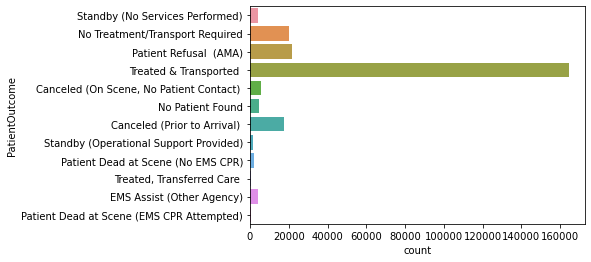

In [19]:
sns.countplot(y='PatientOutcome', data=df)
plt.show()

## 3 Classification analysis _ Decision Tree

In [20]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [21]:
dfr = df[['Shift','FireStation','tenure','PatientOutcome']]
dfr.head()

,Shift,FireStation,tenure,PatientOutcome
0,A - Shift,4,24,Standby (No Services Performed)
1,A - Shift,1,10,No Treatment/Transport Required
2,B - Shift,19,6,Patient Refusal (AMA)
3,A - Shift,35,17,Treated & Transported
4,A - Shift,37,9,Treated & Transported


In [22]:
# A-0， B-1， C-2
labels = dfr['Shift'].unique().tolist()
dfr['Shift'] = dfr['Shift'].apply(lambda x: labels.index(x))

0 'Standby (No Services Performed)',  
1 'No Treatment/Transport Required',  
2 'Patient Refusal (AMA)',  
3 'Treated & Transported ',  
4 'Canceled (On Scene, No Patient Contact) ',  
5 'No Patient Found',  
6 'Canceled (Prior to Arrival) ',  
7 'Standby (Operational Support Provided)',  
8 'Patient Dead at Scene (No EMS CPR)',  
9 'Treated, Transferred Care ',  
10 'EMS Assist (Other Agency)',  
11 'Patient Dead at Scene (EMS CPR Attempted)'  

In [23]:
labels2 = dfr['PatientOutcome'].unique().tolist()
dfr['PatientOutcome'] = dfr['PatientOutcome'].apply(lambda x: labels2.index(x))
dfr.head()

,Shift,FireStation,tenure,PatientOutcome
0,0,4,24,0
1,0,1,10,1
2,1,19,6,2
3,0,35,17,3
4,0,37,9,3


In [24]:
x = dfr.iloc[:,dfr.columns != "PatientOutcome"]
y = dfr.iloc[:,dfr.columns == "PatientOutcome"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=0.2)

In [25]:
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
clf = DecisionTreeClassifier(random_state=10,splitter="random")
clf = clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest)

score

0.6627786890225381

In [26]:
clf = DecisionTreeClassifier(random_state=10,splitter="random")   
score = cross_val_score(clf,x,y,cv=10).mean()

score

0.6603567840284632

0.6658161669093432


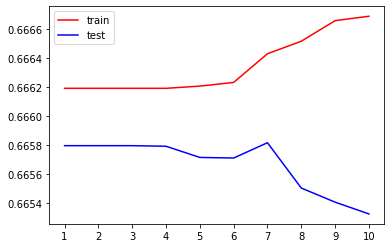

In [27]:
tr = []
te = []
for i in range(10):
    clf = DecisionTreeClassifier(random_state=25
                                ,max_depth=i+1
                                )
    clf = clf.fit(Xtrain, Ytrain)
    score_tr = clf.score(Xtrain, Ytrain) 
    score_te = cross_val_score(clf,x,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
print(max(te))
plt.plot(range(1,11),tr,color="red",label="train")
plt.plot(range(1,11),te,color="blue",label="test")
plt.xticks(range(1,11))
plt.legend()
plt.show()

In [28]:
clf = DecisionTreeClassifier(random_state=10,splitter="random",max_depth=7)
clf = clf.fit(Xtrain, Ytrain)
score = clf.score(Xtest, Ytest)

score

0.6642569305226494

Precition Accuracy Score: 66.4%

In [29]:
# Shift FireStation tenure
clf.feature_importances_

array([0.16461466, 0.54311131, 0.29227403])

Text(0.5, 1.0, 'Feature Importance Ranking')

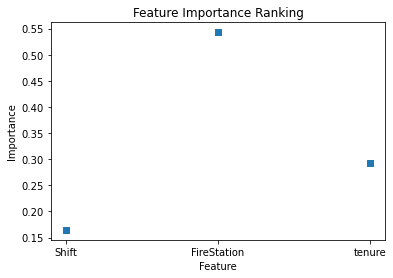

In [30]:
feature = ['Shift', 'FireStation', 'tenure']
importance = clf.feature_importances_
importance= importance.tolist()
plt.scatter(feature,importance,marker="s")
plt.xlabel('Feature')  
plt.ylabel('Importance')
plt.title('Feature Importance Ranking')

The rank of attributes importance:  
1. FireStation  
2. Tenure  
3. Shift 

The result is same with the Cramer'v score for correlation analysis.

Cramer‘v score:   
fire station: 0.0562  
provider tenure: 0.03    
shift: 0.0197    

Cramer'v score measure the strength of association between categorical data.   
The coefficient ranges from 0 to 1.  
0 means the two variables are no association, and 1 means strong association.